# Test Jacknife randomization for ISRSA

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from nltools.data import Brain_Data, Adjacency
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

base_dir = '/Users/lukechang/Dropbox/Mantel_Tests/'

/Users/lukechang/anaconda3/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/lukechang/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/lukechang/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/lukechang/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/kern

# Load Data

In [3]:
dat = pd.read_csv(os.path.join(base_dir,'Data','porn_50rois_isc_w_behavior_isc.csv'),index_col=0)
print(dat.columns)
nacc = Adjacency(dat['ROI34'],matrix_type='distance_flat')
sex = Adjacency(dat['sex_sdi_dyadic_desire'],matrix_type='distance_flat')

Index(['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5', 'ROI6', 'ROI7', 'ROI8', 'ROI9',
       'ROI10', 'ROI11', 'ROI12', 'ROI13', 'ROI14', 'ROI15', 'ROI16', 'ROI17',
       'ROI18', 'ROI19', 'ROI20', 'ROI21', 'ROI22', 'ROI23', 'ROI24', 'ROI25',
       'ROI26', 'ROI27', 'ROI28', 'ROI29', 'ROI30', 'ROI31', 'ROI32', 'ROI33',
       'ROI34', 'ROI35', 'ROI36', 'ROI37', 'ROI38', 'ROI39', 'ROI40', 'ROI41',
       'ROI42', 'ROI43', 'ROI44', 'ROI45', 'ROI46', 'ROI47', 'ROI48', 'ROI49',
       'ROI50', 'sex_sdi_dyadic_desire', 'control_feature_short',
       'control_feature_short_cosine', 'control_feature_short_euclidean',
       'sex_sdi_dyadic_desire_euclidean', 'gonogo_performance_FPFN_euclidean'],
      dtype='object')


# Run Matrix permutation

In [8]:
stats = sex.similarity(nacc, perm_type='jackknife',n_permute=1000)
print(stats)

{'all_r': [-0.12615384615384617, 0.36153846153846153, 0.27076923076923076, 0.062319678013739055, 0.5543373828259135, 0.3646153846153847, 0.3101192996003369, -0.4076923076923077, -0.11230769230769232, -0.15233699070025103, -0.23158300101401796, -0.15833302590864426, 0.363076923076923, 0.14307692307692307, 0.09, 0.03885362641597311, 0.2353846153846154, -0.2053846153846154, -0.17275876615453015, 0.19426813207986557, 0.43846153846153846, -0.2569230769230769, 0.09538461538461537, 0.03808424767506276, 0.10461538461538461, -0.004235659352876352], 'correlation': 0.07066140238238884, 'p': 0.147}


In [194]:


def jacknife_similarity(data1, data2, metric='spearman', p_value='ttest', n_jobs=-1, n_permute=5000, tail=2):
    ''' This function uses a randomization test on a jackknife of absolute distance/similarity of each subject

        Args:
            data1: Adjacency instance
            data2: Adjacency instance
            metric: (str) type of association metric ['spearman','pearson',
                    'kendall']
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            p_value: ['ttest', 'permutation']
            n_permute: (int) number of permutations
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.

        Returns:
            stats: (dict) dictionary of permutation results ['correlation','p']

    '''
    from scipy.stats import pearsonr,spearmanr, kendalltau, ttest_1samp
    from nltools.stats import _calc_pvalue
    from joblib import delayed, Parallel
    import numpy as np

    if metric == 'spearman':
        func = spearmanr
    elif metric == 'pearson':
        func = pearsonr
    elif metric == 'kendall':
        func = kendalltau
    else:
        raise ValueError('metric must be "spearman" or "pearson" or "kendall"')
    
    stats = {}
    stats['all_r'] = []
    for s in range(data1.square_shape()[0]):
        stats['all_r'].append(func(np.delete(data1.squareform()[s,],s),
                             np.delete(data2.squareform()[s,], s))[0])
    stats['correlation'] = np.mean(stats['all_r'])
    
    if p_value == 'permutation':
        all_p = Parallel(n_jobs=n_jobs)(delayed(np.mean)(
                        stats['all_r']*np.random.choice([1,-1],len(stats['all_r'])))
                        for i in range(n_permute))
    
        stats['p'] = _calc_pvalue(all_p, stats['correlation'], tail)
    elif p_value == 'ttest':
        stats['p'] = ttest_1samp(stats['all_r'], 0)[1]
    else:
        raise NotImplementedError("Only ['ttest', 'permutation'] are currently implemented.")
    return stats


# Test Jackknife

In [48]:
from sklearn.metrics import pairwise_distances
from nltools.stats import jackknife_permutation

# Test jackknife_permutation
dat = np.random.multivariate_normal([5, 10, 15, 25, 35, 45], 
                                    [[1, .2, .5, .7, .8, .9], 
                                     [.2, 1, .4, .1, .1, .1],
                                     [.5, .4, 1, .1, .1, .1],
                                     [.7, .1, .1, 1, .3, .6],
                                     [.8, .1, .1, .3, 1, .5],
                                     [.9, .1, .1, .6, .5, 1]], 200)
dat = dat + np.random.randn(dat.shape[0],dat.shape[1])*.5
data1 = pairwise_distances(dat[0:100,:].T,metric='correlation')
data2 = pairwise_distances(dat[100:,:].T,metric='correlation')

stats = jackknife_permutation(data1,data2)
print(stats)
assert (stats['correlation'] >= .4) & (stats['correlation']<=.99) & (stats['p'] <=.05)

/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


{'all_r': [0.9999999999999999, 0.3, 0.6, 0.7999999999999999, 0.8999999999999998, 0.9999999999999999], 'correlation': 0.7666666666666666, 'p': 0.0278}


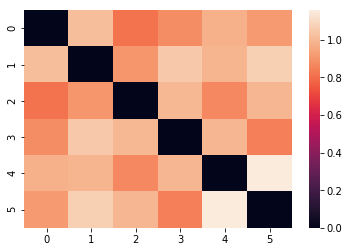

In [17]:
sns.heatmap(data1)


In [18]:
data1 = dat_roi; data2=sex; n_jobs=-1; n_permute=5000;
func = spearmanr

stats = {}
stats['all_r'] = []
for s in range(data1.square_shape()[0]):
    stats['all_r'].append(func(np.delete(data1.squareform()[s,],s),
                         np.delete(data2.squareform()[s,], s))[0])
stats['correlation'] = np.mean(stats['all_r'])
all_p = Parallel(n_jobs=n_jobs)(delayed(np.mean)(
            stats['all_r']*np.random.choice([1,-1],len(stats['all_r'])))
            for i in range(n_permute))

NameError: name 'dat_roi' is not defined

0.06449053790193442


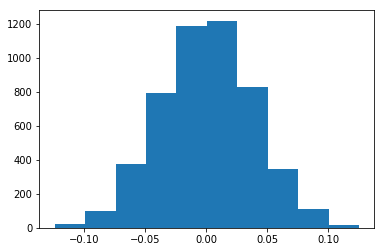

In [206]:
plt.hist(all_p)
print(stats['correlation'])

# Run Jackknife permutation

In [203]:
jacknife_stats = {}
for r in range(50):
    roi = 'ROI%s' % (r+1)
    dat_roi = Adjacency(dat[roi],matrix_type='distance_flat')
    jacknife_stats[roi] = jacknife_similarity(dat_roi,sex, p_value='permutation')
[(jacknife_stats[x]['correlation'],jacknife_stats[x]['p']) for x in jacknife_stats]

[(0.10493948638972533, 0.0288),
 (0.06462601754552454, 0.0718),
 (0.08512878147089809, 0.059),
 (-0.039659263701756445, 0.3554),
 (0.04591390312881562, 0.2262),
 (0.04535864123204361, 0.2906),
 (0.12151258834292425, 0.011),
 (0.09656697930393496, 0.041),
 (-0.009007694480674107, 0.84),
 (0.014867058694203055, 0.7002),
 (0.05998331360277103, 0.0952),
 (0.03678543304022068, 0.391),
 (0.06136593504448099, 0.1116),
 (0.009071036674196063, 0.8434),
 (0.02498083131130083, 0.4898),
 (-0.03472929057555156, 0.3194),
 (0.01941715291348448, 0.6016),
 (0.04254136437944758, 0.1904),
 (-0.01218360192456531, 0.8022),
 (0.06730885161145003, 0.077),
 (0.10355176460595536, 0.0126),
 (0.07474244008075363, 0.0272),
 (0.012495450605763724, 0.8038),
 (0.0525807106194146, 0.1974),
 (0.03804541677001392, 0.2194),
 (0.011585798859327083, 0.792),
 (0.03226817900679024, 0.3988),
 (0.12470459220049278, 0.002),
 (0.05874200773956422, 0.2248),
 (0.009720216743337614, 0.7156),
 (-0.09944733631617811, 0.0082),
 (-0.0

## Try using one-sample t-test

In [186]:
from scipy.stats import ttest_1samp
jacknife_ttest_p = [ttest_1samp(jacknife_stats[x]['all_r'],0)[1] for x in jacknife_stats]

# Run Matrix Permutation

In [193]:
mantel_stats = {}
for r in range(50):
    roi = 'ROI%s' % (r+1)
    dat_roi = Adjacency(dat[roi],matrix_type='distance_flat')
    mantel_stats[roi] = dat_roi.similarity(sex,n_permute=5000)
[(mantel_stats[x]['correlation'],mantel_stats[x]['p']) for x in mantel_stats]

/Users/lukechang/anaconda3/lib/python3.6/site-packages/nltools/stats.py:537: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  new_fmri_dist = data1.iloc[permuted_ix,permuted_ix].as_matrix()


[(0.20203166921817547, 0.0134),
 (0.12759737588527165, 0.1844),
 (0.18353032850213696, 0.0124),
 (0.019026929110305207, 0.7772),
 (0.12940783301457467, 0.1684),
 (0.11584146493695498, 0.1268),
 (0.1815186900486567, 0.0376),
 (0.1700485579578811, 0.0214),
 (0.024659132245807427, 0.7004),
 (0.058820455201928676, 0.4022),
 (0.11806896693114671, 0.0976),
 (0.057432985739444845, 0.5128),
 (0.11506925026257181, 0.1172),
 (0.06100093914555249, 0.3432),
 (0.1133353504051972, 0.1292),
 (-0.021705909262924223, 0.772),
 (0.04072759472446721, 0.5274),
 (0.08996353393051518, 0.2138),
 (0.05294442239898316, 0.5088),
 (0.12698561686301246, 0.0926),
 (0.15779572389519791, 0.0648),
 (0.11006226484781849, 0.158),
 (0.09810167680948309, 0.2364),
 (0.10263848171855722, 0.178),
 (0.04841146283233467, 0.6078),
 (0.09368407751560347, 0.2234),
 (0.03166394783896718, 0.5444),
 (0.1158998442265077, 0.1536),
 (0.13163026614829626, 0.0846),
 (0.03735016055672028, 0.578),
 (-0.07794701363871609, 0.2448),
 (0.01292

# Compare values from each test

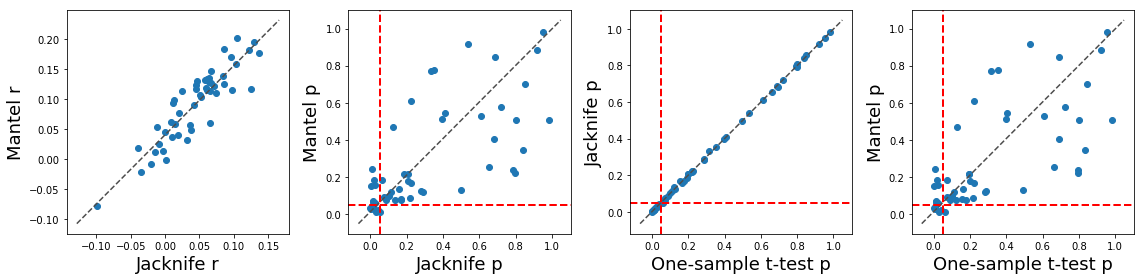

In [195]:
f,a = plt.subplots(ncols=4,figsize = (16,4))
a[0].scatter([jacknife_stats[x]['correlation'] for x in jacknife_stats],[mantel_stats[x]['correlation'] for x in mantel_stats])
a[0].set_ylabel('Mantel r',fontsize=18)
a[0].set_xlabel('Jacknife r',fontsize=18)
a[0].plot(a[0].get_xlim(), a[0].get_ylim(), ls="--", c=".3")

a[1].scatter([jacknife_stats[x]['p'] for x in jacknife_stats],[mantel_stats[x]['p'] for x in mantel_stats])
a[1].set_ylabel('Mantel p',fontsize=18)
a[1].set_xlabel('Jacknife p',fontsize=18)
a[1].plot(a[1].get_xlim(), a[1].get_ylim(), ls="--", c=".3")
a[1].axhline(y=0.05, ls='--',linewidth=2, color='r')
a[1].axvline(x=0.05, ls='--',linewidth=2, color='r')

a[2].scatter([ttest_1samp(jacknife_stats[x]['all_r'],0)[1] for x in jacknife_stats],[jacknife_stats[x]['p'] for x in jacknife_stats])
a[2].set_ylabel('Jacknife p',fontsize=18)
a[2].set_xlabel('One-sample t-test p',fontsize=18)
a[2].plot(a[2].get_xlim(), a[2].get_ylim(), ls="--", c=".3")
a[2].axhline(y=0.05, ls='--',linewidth=2, color='r')
a[2].axvline(x=0.05, ls='--',linewidth=2, color='r')

a[3].scatter([ttest_1samp(jacknife_stats[x]['all_r'],0)[1] for x in jacknife_stats],[mantel_stats[x]['p'] for x in mantel_stats])
a[3].set_ylabel('Mantel p',fontsize=18)
a[3].set_xlabel('One-sample t-test p',fontsize=18)
a[3].plot(a[3].get_xlim(), a[3].get_ylim(), ls="--", c=".3")
a[3].axhline(y=0.05, ls='--',linewidth=2, color='r')
a[3].axvline(x=0.05, ls='--',linewidth=2, color='r')

plt.tight_layout()

In [196]:
thresh = 0.05
print(len([jacknife_stats[x]['p'] for x in jacknife_stats if jacknife_stats[x]['p'] < thresh]))
print(len([ttest_1samp(jacknife_stats[x]['all_r'],0)[1] for x in jacknife_stats if ttest_1samp(jacknife_stats[x]['all_r'],0)[1] < thresh]))
print(len([mantel_stats[x]['p'] for x in mantel_stats if mantel_stats[x]['p'] < thresh]))


12
12
6


# Test on Jeroen's data

In [160]:
brain = Adjacency(pd.read_csv(os.path.join(base_dir,'Data','ISRSA_data_parcel141_moralStrategyModel','brainDistanceVector.csv'),index_col=0).values.flatten(),matrix_type='distance_flat')
model = Adjacency(pd.read_csv(os.path.join(base_dir,'Data','ISRSA_data_parcel141_moralStrategyModel','modelDistanceVector.csv'),index_col=0).values.flatten(),matrix_type='distance_flat')

In [161]:
jackknife_stats = jacknife_similarity(brain, model, n_permute=5000)
mantel_stats = brain.similarity(model, n_permute=5000)

/Users/lukechang/anaconda3/lib/python3.6/site-packages/nltools/stats.py:537: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  new_fmri_dist = data1.iloc[permuted_ix,permuted_ix].as_matrix()


In [178]:
print('Matrix Permutation: r: %s, p: %s' % (mantel_stats['correlation'],mantel_stats['p']))
print('Jackknife Randomization: r: %s, p: %s' % (jackknife_stats['correlation'],jackknife_stats['p']))
print('Jackknife ttest: r: %s, p: %s' % (np.mean(jackknife_stats['all_r']),ttest_1samp(jackknife_stats['all_r'],0)[1]))

Matrix Permutation: r: 0.15541206960826554, p: 0.0176
Jackknife Randomization: r: 0.09291650178076771, p: 0.0544
Jackknife ttest: r: 0.09291650178076771, p: 5.789066126184961e-05


In [49]:
dat = np.random.multivariate_normal([2, 6], [[.5, 2], [.5, 3]], 190)
x = dat[:, 0]
y = dat[:, 1]
stats = matrix_permutation(x,y,n_permute=1000)
data_row_id = range(data1.shape[0])
permuted_ix = random_state.choice(data_row_id,
                   size=len(data_row_id))
new_fmri_dist = data1.iloc[permuted_ix, permuted_ix].values()
assert (stats['correlation'] > .4) & (stats['correlation']<.85) & (stats['p'] <.001)

/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


NameError: name 'matrix_permutation' is not defined

In [63]:
from scipy.spatial.distance import squareform
def _check_square_matrix(data):
    '''Helper function to make sure matrix is square and numpy array'''

    from nltools.data import Adjacency

    if isinstance(data, Adjacency):
        data = data.squareform()
    elif isinstance(data, pd.DataFrame):
        data = data.values

    if data.shape[0] != data.shape[1]:
        raise ValueError('Make sure data is square.')
    return np.array(data)

y_sq = squareform(y)
sq_data1 = pd.DataFrame(_check_square_matrix(y_sq))
sq_data1
# y2 = y_sq[np.triu_indices(y_sq.shape[0], k=1)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,7.469361,4.960962,5.984303,6.202347,3.761552,7.834239,8.302389,4.495984,4.655943,4.806681,6.499594,8.022895,2.916801,7.300622,10.351580,6.379292,7.293137,4.952709,2.363822
1,7.469361,0.000000,4.271724,4.934174,8.430539,6.734554,5.807866,9.353464,6.718462,2.941327,6.607594,4.429705,3.565277,10.373624,6.738472,7.677133,6.071600,4.944799,5.355375,4.371892
2,4.960962,4.271724,0.000000,5.421047,7.436768,3.968474,4.077382,5.728165,9.934500,7.681615,3.068024,5.121671,2.732884,0.968011,7.487609,5.065965,3.328869,6.139477,4.746546,4.360221
3,5.984303,4.934174,5.421047,0.000000,3.805789,8.537295,6.207866,6.577680,6.194510,10.609268,5.609952,3.978742,6.379840,5.281343,5.702251,5.608250,6.008536,6.113400,6.606924,5.082074
4,6.202347,8.430539,7.436768,3.805789,0.000000,4.209072,1.509596,4.724215,4.481889,3.899965,7.668555,8.142718,5.897223,5.229345,4.529510,5.693819,2.252196,7.665199,6.538124,6.212392
5,3.761552,6.734554,3.968474,8.537295,4.209072,0.000000,10.687868,4.763623,6.373508,5.538379,6.555860,7.723287,3.725848,4.526783,8.948907,11.455871,5.482513,6.349543,7.860064,9.666229
6,7.834239,5.807866,4.077382,6.207866,1.509596,10.687868,0.000000,7.525795,2.616140,5.596866,4.784446,6.417096,2.415467,4.347460,7.549922,6.656453,5.729250,4.450594,3.365597,7.189151
7,8.302389,9.353464,5.728165,6.577680,4.724215,4.763623,7.525795,0.000000,7.014494,4.345496,6.501744,6.021810,5.945140,9.136176,4.219721,3.657767,7.116776,5.553848,8.542761,3.997443
8,4.495984,6.718462,9.934500,6.194510,4.481889,6.373508,2.616140,7.014494,0.000000,7.641587,3.858636,6.770983,7.084279,6.178303,2.773886,4.707913,6.327651,5.811698,4.276601,4.558895
9,4.655943,2.941327,7.681615,10.609268,3.899965,5.538379,5.596866,4.345496,7.641587,0.000000,7.955182,7.091899,3.910963,5.870886,3.264338,6.102794,7.081648,7.464397,6.918362,7.611357


In [61]:
from sklearn.metrics import pairwise_distances
n = 10
sim = np.random.multivariate_normal([0,0,0,0],[[1, 0.8, 0.1, 0.4],
                                     [0.8, 1, 0.6, 0.1],
                                     [0.1, 0.6, 1, 0.3],
                                     [0.4, 0.1, 0.3, 1]], 100)
data = pairwise_distances(sim.T, metric='correlation')
dat_all = []
for t in range(n):
    tmp = data
    dat_all.append(tmp)
labels = ['v_%s' % (x+1) for x in range(sim.shape[1])]
sim_adjacency_multiple =  Adjacency(dat_all, labels=labels)

# assert len(sim_adjacency_multiple.similarity(
#             sim_adjacency_multiple[0].squareform(),perm_type='1d' )) == len(sim_adjacency_multiple)
# assert len(sim_adjacency_multiple.similarity(sim_adjacency_multiple[0].squareform(),perm_type='1d',
#             metric='pearson',n_permute=1000)) == len(sim_adjacency_multiple)
# assert len(sim_adjacency_multiple.similarity(sim_adjacency_multiple[0].squareform(),perm_type='1d',
#             metric='kendall',n_permute=1000)) == len(sim_adjacency_multiple)

data2 = sim_adjacency_multiple[0].copy()
data2.data = data2.data + np.random.randn(len(data2.data))*.1
assert sim_adjacency_multiple[0].similarity(data2.squareform(), perm_type='1d', n_permute=1000)['correlation'] > .5
assert sim_adjacency_multiple[0].similarity(data2.squareform(), perm_type='2d', n_permute=1000)['correlation'] > .5
assert sim_adjacency_multiple[0].similarity(data2.squareform(), perm_type='jackknife', n_permute=1000)['correlation'] > .5


/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.
/Users/lukechang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lukechang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/lukechang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  

In [56]:
print(sim_adjacency_multiple[0].data)
print(data2.data)

[0.21924273 0.77286577 0.5276275  0.38000671 0.79310164 0.63364318]
[0.23880844 0.77939868 0.43448294 0.13268383 0.91145979 0.66725438]


In [33]:
sim = np.random.multivariate_normal([0,0,0,0],[[1, 0.8, 0.1, 0.4],
                                     [0.8, 1, 0.6, 0.1],
                                     [0.1, 0.6, 1, 0.3],
                                     [0.4, 0.1, 0.3, 1]], 100)
data = pairwise_distances(sim.T, metric='correlation')
labels = ['v_%s' % (x+1) for x in range(sim.shape[1])]
sim_adjacency_single = Adjacency(data, labels=labels)

assert len(sim_adjacency_single.similarity(sim_adjacency_multiple[0].squareform(),perm_type='1d' )) == len(sim_adjacency_multiple)
assert len(sim_adjacency_single.similarity(sim_adjacency_multiple[0].squareform(),perm_type='1d',
            metric='pearson',n_permute=1000)) == len(sim_adjacency_multiple)
assert len(sim_adjacency_single.similarity(sim_adjacency_multiple[0].squareform(),perm_type='1d',
            metric='kendall',n_permute=1000)) == len(sim_adjacency_multiple)


/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


AssertionError: 

# Simulation to test Type 1 Error

## Homogenous structure
Peres-Neto PR, Jackson DA. 2001. How well do multivariate data sets match? The advantages of a Procrustean superimposition approach over the Mantel
test. Oecologia 129(2): 169–178.

Omelka, M. and Hudecová, Š. (2013) A comparison of the Mantel test with a generalised distance covariance test. Environmetrics, Vol. 24, 449–460. DOI: 10.1002/env.2238. 

In [11]:
n_variables = 6
r_within = .8
r_between = .4
n_samples = 10
n_simulations = 100
n_permutations = 1000
dist_metric = 'euclidean'
alpha = 0.05
z = np.ones((n_variables*2,n_variables*2)) * r_within
z[np.diag_indices(n_variables*2)] = 1
z[n_variables:,:n_variables] = r_between
z[:n_variables,n_variables:] = r_between

r = []; p = []
for i in range(n_simulations):
    sim = np.random.multivariate_normal(np.zeros(n_variables*2),z, n_samples)
    X = Adjacency(pairwise_distances(sim[:,:n_variables].T, metric=dist_metric), matrix_type='distance')
    Y = Adjacency(pairwise_distances(sim[:,n_variables:].T, metric=dist_metric), matrix_type='distance')
    stats = X.similarity(Y, perm_type='2d', n_permute=n_permutations, metric='pearson')
    r.append(stats['correlation'])
    p.append(stats['p'])

## Plot
# f,a = plt.subplots(ncols=2, figsize=(10,5))
# sns.heatmap(X.squareform(),ax=a[0],square=True)
# sns.heatmap(Y.squareform(),ax=a[1],square=True)

/Users/lukechang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/lukechang/anaconda3/lib/python3.6/site-packages/nltools-0.3.10-py3.6.egg/nltools/stats.py:451: RuntimeWarning: invalid value encountered in greater_equal
  p= np.mean( np.abs(all_p) >= np.abs(stat))


In [17]:
alpha = 0.05
np.mean([x > alpha for x in p])

0.94

(array([ 1.,  2., 10., 11., 18., 22., 17., 11.,  5.,  3.]),
 array([-0.79083181, -0.63950989, -0.48818796, -0.33686603, -0.1855441 ,
        -0.03422217,  0.11709975,  0.26842168,  0.41974361,  0.57106554,
         0.72238746]),
 <a list of 10 Patch objects>)

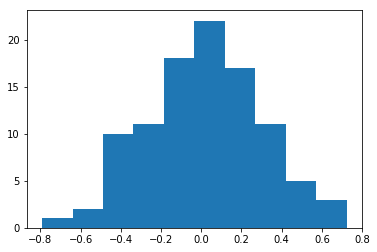

In [15]:
plt.hist(r)

(array([12., 11., 10., 11., 10.,  8.,  9., 11.,  4., 14.]),
 array([0.001 , 0.1006, 0.2002, 0.2998, 0.3994, 0.499 , 0.5986, 0.6982,
        0.7978, 0.8974, 0.997 ]),
 <a list of 10 Patch objects>)

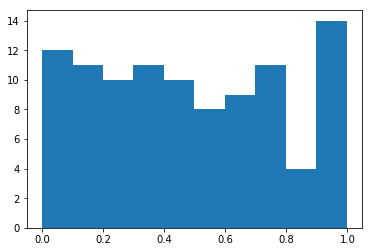

In [18]:
plt.hist(p)

In [19]:
np.sum([x > alpha for x in p])

94

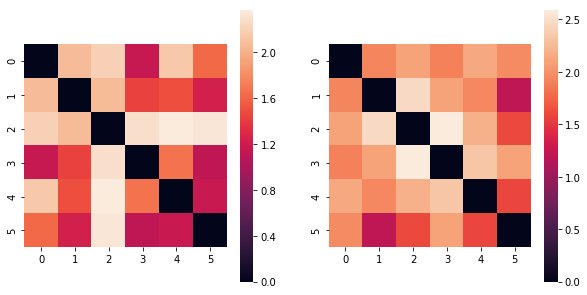

In [20]:
# Plot
f,a = plt.subplots(ncols=2, figsize=(10,5))
sns.heatmap(X.squareform(),ax=a[0],square=True)
sns.heatmap(Y.squareform(),ax=a[1],square=True)

In [22]:
x = []
for i in range(n_simulations):
    sim = np.random.multivariate_normal(np.zeros(n_variables*2),z, n_samples)
    X = Adjacency(pairwise_distances(sim[:,:n_variables].T, metric=dist_metric), matrix_type='distance')
    x.append(X)
x = Adjacency(x)

## Heterogeneous structure
Peres-Neto PR, Jackson DA. 2001. How well do multivariate data sets match? The advantages of a Procrustean superimposition approach over the Mantel
test. Oecologia 129(2): 169–178.

Omelka, M. and Hudecová, Š. (2013) A comparison of the Mantel test with a generalised distance covariance test. Environmetrics, Vol. 24, 449–460. DOI: 10.1002/env.2238. 

In [81]:
n_variables = 6
r_within_1 = .8
r_within_2 = .2
r_between_1 = .8
r_between_2 = .2
n_samples = 10
n_simulations = 100
n_permutations = 1000
dist_metric = 'euclidean'
alpha = 0.05
permutation_type = 'jackknife'

z = np.zeros((n_variables*2,n_variables*2))
z[:int(n_variables/2),:int(n_variables/2)] = r_within_1
z[int(n_variables/2):n_variables,int(n_variables/2):n_variables] = r_within_2
z[n_variables:int(n_variables + (n_variables/2)),n_variables:int(n_variables + (n_variables/2))] = r_within_1
z[int(n_variables + (n_variables/2)):,int(n_variables + (n_variables/2)):] = r_within_2
z[n_variables:int(n_variables + (n_variables/2)),:int(n_variables/2)] = r_between_1
z[int(n_variables + (n_variables/2)):,int(n_variables/2):n_variables] = r_between_2
z[:int(n_variables/2), n_variables:int(n_variables+(n_variables/2))] = r_between_1
z[int(n_variables/2):n_variables,int(n_variables + (n_variables/2)):] = r_between_2
z[np.diag_indices(n_variables*2)] = 1

r = []; p = []; x = []; y = []
for i in range(n_simulations):
    sim = np.random.multivariate_normal(np.zeros(n_variables*2),z, n_samples)
    X = Adjacency(pairwise_distances(sim[:,:n_variables].T, metric=dist_metric), matrix_type='distance')
    Y = Adjacency(pairwise_distances(sim[:,n_variables:].T, metric=dist_metric), matrix_type='distance')
    stats = X.similarity(Y, perm_type=permutation_type, n_permute=n_permutations, metric='pearson')
    r.append(stats['correlation'])
    p.append(stats['p'])
    x.append(X)
    y.append(Y)

## Plot Simulated Distribution of r and p

(array([46., 17., 11.,  7.,  5.,  2.,  5.,  2.,  1.,  4.]),
 array([0.02 , 0.118, 0.216, 0.314, 0.412, 0.51 , 0.608, 0.706, 0.804,
        0.902, 1.   ]),
 <a list of 10 Patch objects>)

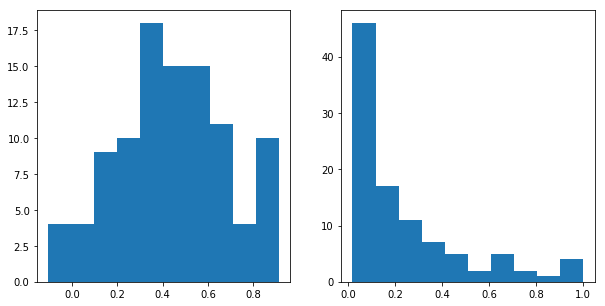

In [82]:
f,a = plt.subplots(ncols=2, figsize=(10,5))
a[0].hist(r)
a[1].hist(p)

## Type 1 Error Rate

In [84]:
np.mean([x > alpha for x in p])

0.75

## Plot Average Distance Matrices

/Users/lukechang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/lukechang/anaconda3/lib/python3.6/site-packages/nltools-0.3.10-py3.6.egg/nltools/stats.py:451: RuntimeWarning: invalid value encountered in greater_equal
  p= np.mean( np.abs(all_p) >= np.abs(stat))


{'correlation': 0.9884422213072189, 'p': 0.0}

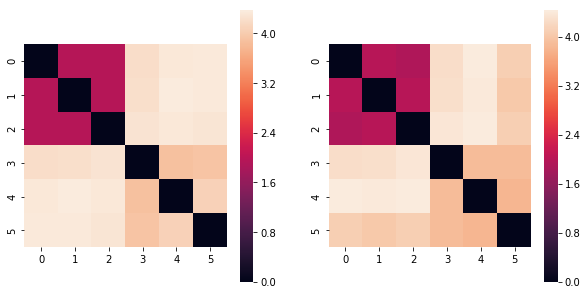

In [85]:
x_mn = Adjacency(x).mean()
y_mn = Adjacency(y).mean()

f,a = plt.subplots(ncols=2, figsize=(10,5))
sns.heatmap(x_mn.squareform(),ax=a[0],square=True)
sns.heatmap(y_mn.squareform(),ax=a[1],square=True)
stats = x_mn.similarity(y_mn, perm_type='2d', n_permute=n_permutations, metric='pearson')
stats

In [87]:
XX = Adjacency(z[], matrix_type='similarity')
YY = Adjacency(pairwise_distances(sim[:,n_variables:].T, metric=dist_metric), matrix_type='distance')
stats = X.similarity(Y, perm_type=permutation_type, n_permute=n_permutations, metric='pearson')


## Find parameter combinations that result in low medium and high correlation

In [108]:
n_variables = 6
r_within_1 = .8
r_within_2 = .2
r_between_1 = .8
r_between_2 = .2
n_samples = 10
n_simulations = 100
n_permutations = 0
dist_metric = 'euclidean'
alpha = 0.05
permutation_type = None

def create_heterogeneous_simulation(r_within_1, r_within_2, r_between_1, r_between_2):
    '''Create a heterogeneous multivariate covariance matrix based on:
        Omelka, M. and Hudecová, Š. (2013) A comparison of the Mantel test 
        with a generalised distance covariance test. Environmetrics, 
        Vol. 24, 449–460. DOI: 10.1002/env.2238. 
    '''
    z = np.zeros((n_variables*2,n_variables*2))
    z[:int(n_variables/2),:int(n_variables/2)] = r_within_1
    z[int(n_variables/2):n_variables,int(n_variables/2):n_variables] = r_within_2
    z[n_variables:int(n_variables + (n_variables/2)),n_variables:int(n_variables + (n_variables/2))] = r_within_1
    z[int(n_variables + (n_variables/2)):,int(n_variables + (n_variables/2)):] = r_within_2
    z[n_variables:int(n_variables + (n_variables/2)),:int(n_variables/2)] = r_between_1
    z[int(n_variables + (n_variables/2)):,int(n_variables/2):n_variables] = r_between_2
    z[:int(n_variables/2), n_variables:int(n_variables+(n_variables/2))] = r_between_1
    z[int(n_variables/2):n_variables,int(n_variables + (n_variables/2)):] = r_between_2
    z[np.diag_indices(n_variables*2)] = 1
    return z

results = {}
simulation = 1
for n_variables in [6, 12, 24, 48]:
    for n_samples in [10,20,50,100]:
        for param1 in np.arange(0.1,1,.2):
            for param2 in np.arange(0.1,1,.2):
                z = create_heterogeneous_simulation(param1, param2, param2, param2)
                r = []; x = []; y = []
                for i in range(n_simulations):
                    sim = np.random.multivariate_normal(np.zeros(n_variables*2),z, n_samples)
                    X = Adjacency(pairwise_distances(sim[:,:n_variables].T, metric=dist_metric), matrix_type='distance')
                    Y = Adjacency(pairwise_distances(sim[:,n_variables:].T, metric=dist_metric), matrix_type='distance')
                    stats = X.similarity(Y, perm_type=permutation_type, n_permute=n_permutations, metric='pearson')
                    r.append(stats['correlation'])
                    p.append(stats['p'])
                    x.append(X)
                    y.append(Y)

                # Calculate statistic on average
                x_mn = Adjacency(x).mean()
                y_mn = Adjacency(y).mean()
                mn_stats = x_mn.similarity(y_mn, perm_type=permutation_type, n_permute=n_permutations, metric='pearson')

    #             print('Parameter 1: %s; Parameter 2: %s' % (param1, param2))
    #             print('Average r: %s' % np.mean(r))
    #             print('r of Mean matrix: %s' % mn_stats['correlation'])

                # Save results
                results[simulation] = {'param1':param1,'param2':param2, 'mean_r':np.mean(r), 'r':r, 
                                       'r_of_matrix_means':mn_stats['correlation'], 'n_variables':n_variables, 
                                       'n_samples':n_samples, 'n_simulations':n_simulations}
                simulation += 1
                
sim_results = pd.DataFrame(results).T
sim_results.to_csv(os.path.join(base_dir, 'Analyses','Simulation_Parameter_Search.csv'),index=None)

/Users/lukechang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lukechang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lukechang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: covariance is not positive-semidefinite.


/Users/lukechang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


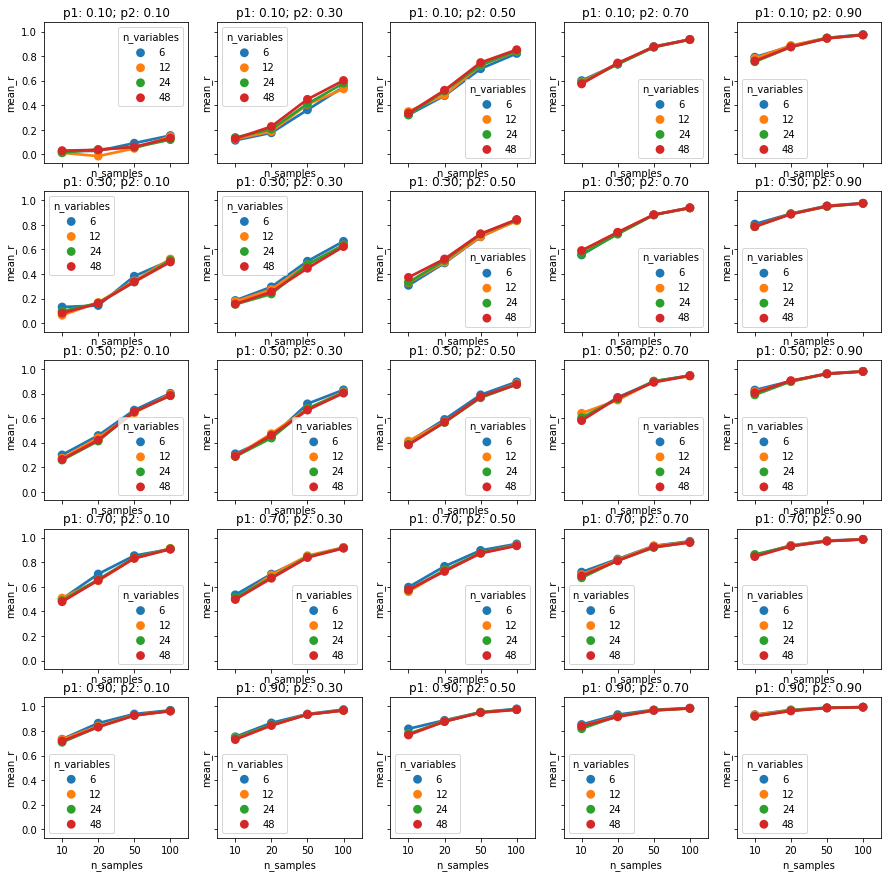

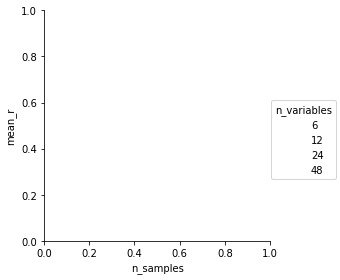

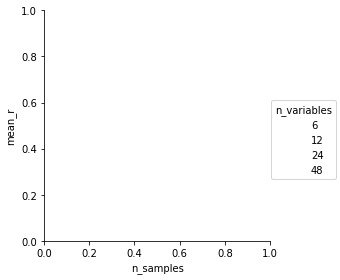

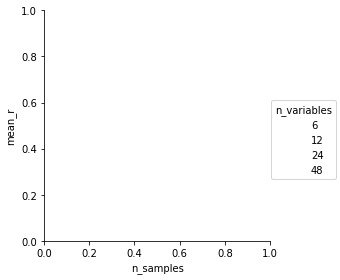

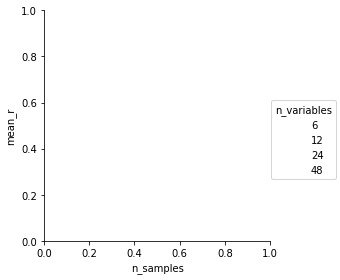

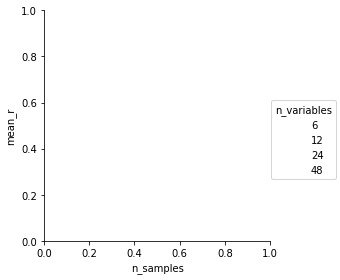

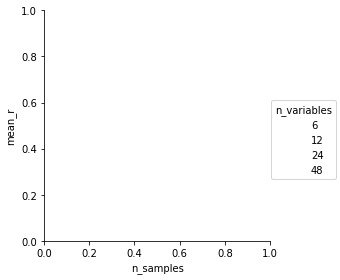

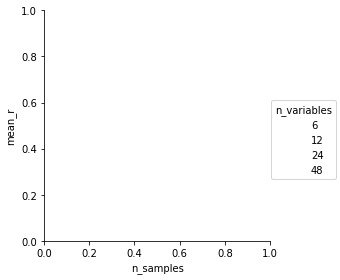

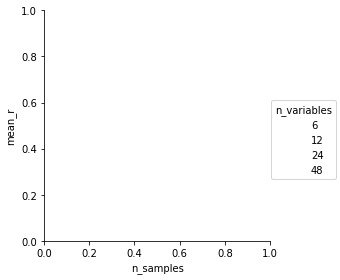

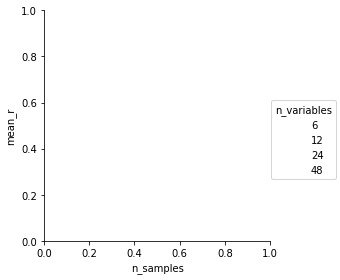

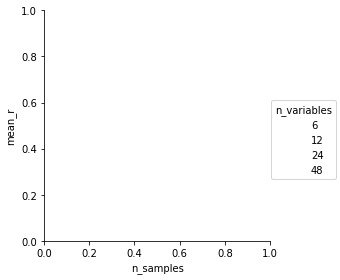

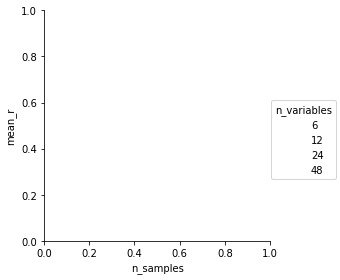

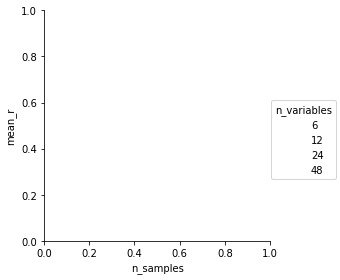

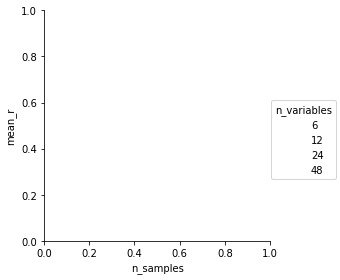

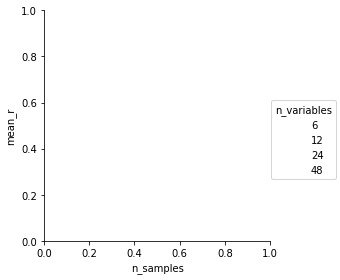

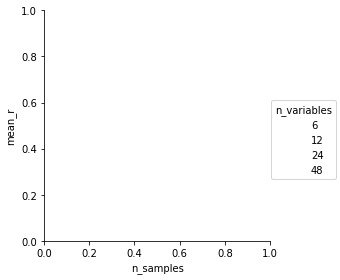

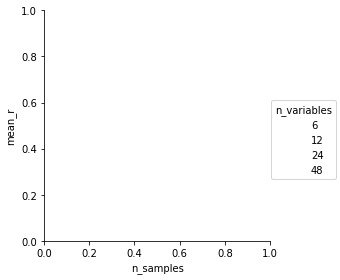

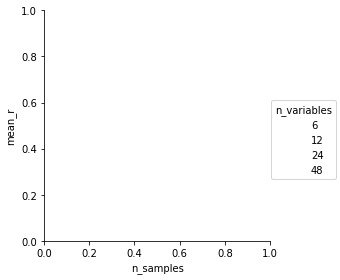

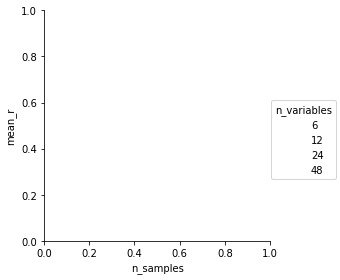

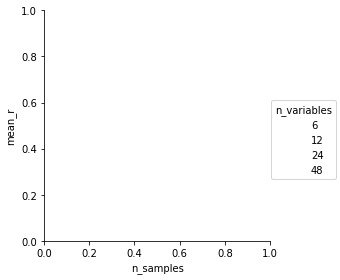

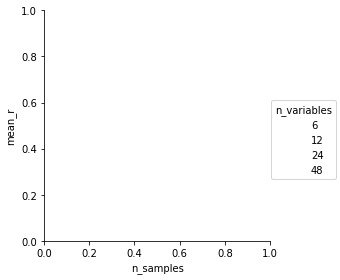

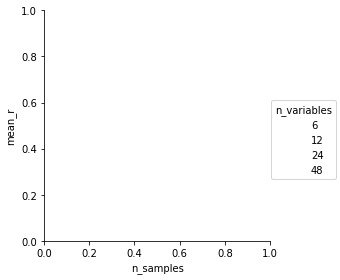

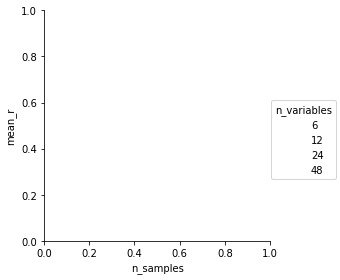

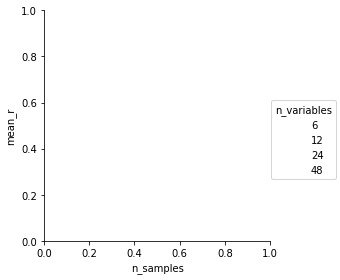

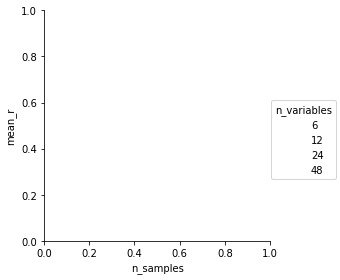

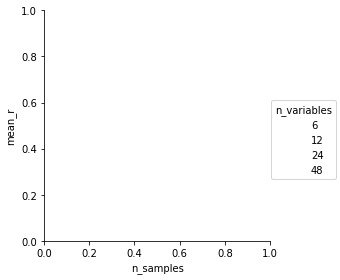

In [139]:
sim_results = pd.DataFrame(results).T
sim_results.drop('r',axis=1, inplace=True)
# sns.factorplot(y='mean_r', x = 'n_samples', hue='n_variables', data=sim_results)
sim_results.head()
f, a = plt.subplots(nrows=len(sim_results['param1'].unique()), 
                    ncols=len(sim_results['param1'].unique()),
                    figsize=(15,15),
                    sharex=True, sharey=True)
for i, param1 in enumerate(sim_results['param1'].unique()):
    for j, param2 in enumerate(sim_results['param2'].unique()):
        tmp_dat = sim_results.query("param1== %s & param2 == %s" % (param1, param2))
        sns.factorplot(y='mean_r', x = 'n_samples', hue='n_variables', data=tmp_dat, ax = a[i,j])
        a[i,j].set_title('p1: %0.2f; p2: %0.2f' % (param1, param2))
f.savefig(os.path.join(base_dir,'Figures','Simulation_Parameter_Search_Results.png'))

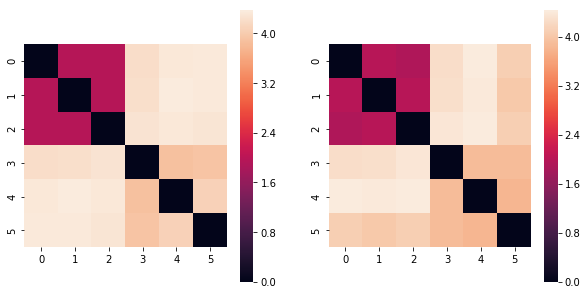

In [97]:
f,a = plt.subplots(ncols=2, figsize=(10,5))
sns.heatmap(x_mn.squareform(),ax=a[0],square=True)
sns.heatmap(y_mn.squareform(),ax=a[1],square=True)


(array([  2.,   7.,  22.,  26.,  29.,  59.,  92., 118., 110.,  35.]),
 array([-0.05160156,  0.05093606,  0.15347368,  0.25601131,  0.35854893,
         0.46108655,  0.56362417,  0.66616179,  0.76869941,  0.87123703,
         0.97377465]),
 <a list of 10 Patch objects>)

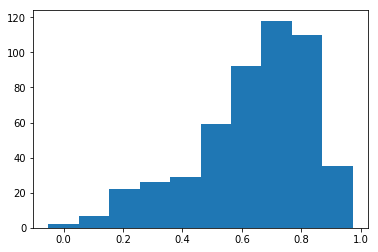

In [100]:
plt.hist(r)

In [103]:
np.arange(0.1,1,.2)

array([0.1, 0.3, 0.5, 0.7, 0.9])